# Preparation

In [21]:
# !pip install sagemaker

In [106]:
# Amazon SageMaker Python SDK : https://sagemaker.readthedocs.io/en/stable/
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'sagemaker/xgboost-churn-prediction'

# Define IAM role
import boto3      
from sagemaker import get_execution_role

role = get_execution_role()

# Show Information
print("SageMaker SDK Ver : ", sagemaker.__version__)
print("AWS SDK Session : ", boto3.Session())
print("SageMaker Default Bucket : ", bucket, ", Prefix : ", prefix)
print("SageMaker IAM Role : ", role)

SageMaker SDK Ver :  2.16.1
AWS SDK Session :  Session(region_name='us-east-1')
SageMaker Default Bucket :  sagemaker-us-east-1-189427507247 , Prefix :  sagemaker/xgboost-churn-prediction
SageMaker IAM Role :  arn:aws:iam::189427507247:role/rainny-sagemaker-full-access-role


In [107]:
# Import Python Library
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

---

# Data Load

In [108]:
churn_train = pd.read_csv('s3://sagemaker-us-east-1-189427507247/datasets/train.csv')
#churn_eval = pd.read_csv('s3://sagemaker-us-east-1-189427507247/datasets/test.csv')
#churn_answer = pd.read_csv('s3://sagemaker-us-east-1-189427507247/datasets/sampleSubmission.csv')
churn_train.shape #, churn_eval.shape, churn_answer.shape

(4250, 20)

### EDA (Exploratory Data Analysis)

- Features descrption
    - churn : 86% is 'no'
    - internaltional_plan : 90% is 'no'
    - voice_mail_plan : 74% is 'no'
    - number_vmall_messages : over 3000 count is 0

col_0,% observations
state,
AK,0.014353
AL,0.023765
AR,0.016706
AZ,0.018118
CA,0.009176
CO,0.018824
CT,0.020706
DC,0.016941
DE,0.018824


col_0,% observations
area_code,
area_code_408,0.255529
area_code_415,0.496000
area_code_510,0.248471


col_0,% observations
international_plan,
no,0.906824
yes,0.093176


col_0,% observations
voice_mail_plan,
no,0.738353
yes,0.261647


col_0,% observations
churn,
no,0.859294
yes,0.140706


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


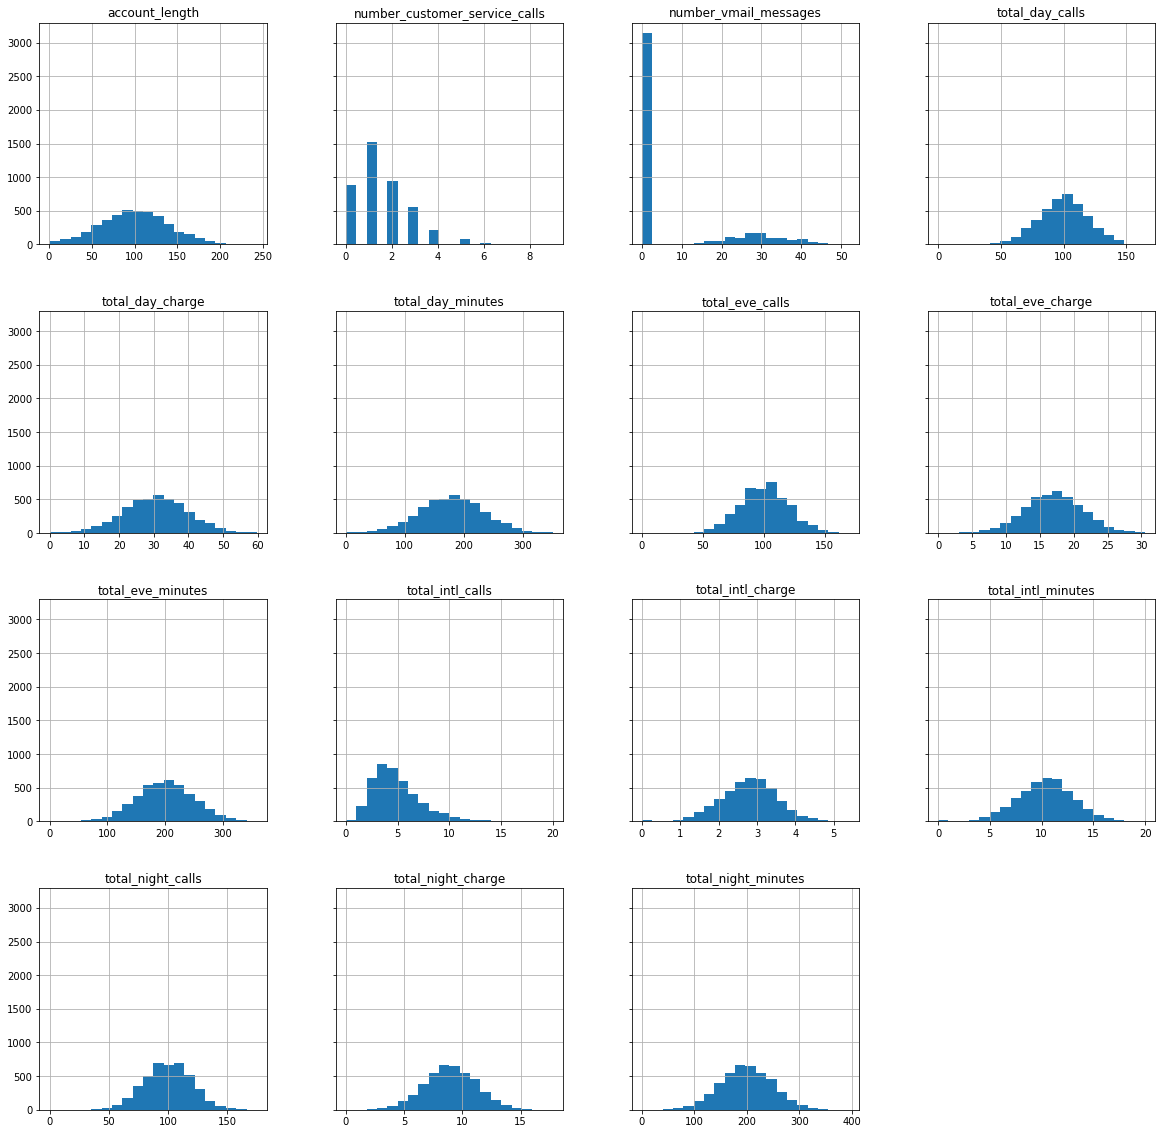

In [109]:
# Frequency tables for each categorical feature
for column in churn_train.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn_train[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn_train.describe())
%matplotlib inline
hist = churn_train.hist(bins=20, sharey=True, figsize=(20, 20))

- Relation with 'churn'

churn,no,yes
state,,
AK,0.015608,0.006689
AL,0.024096,0.021739
AR,0.016429,0.018395
AZ,0.019168,0.011706
CA,0.007941,0.016722
CO,0.019441,0.015050
CT,0.019989,0.025084
DC,0.017525,0.013378
DE,0.018346,0.021739


churn,no,yes
area_code,,
area_code_408,0.255750,0.254181
area_code_415,0.498631,0.479933
area_code_510,0.245619,0.265886


churn,no,yes
international_plan,,
no,0.937295,0.720736
yes,0.062705,0.279264


churn,no,yes
voice_mail_plan,,
no,0.717963,0.862876
yes,0.282037,0.137124


account_length


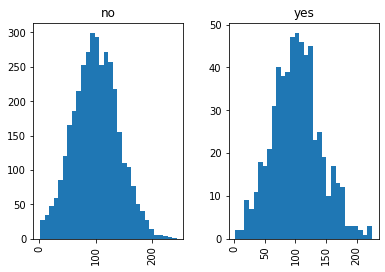

number_vmail_messages


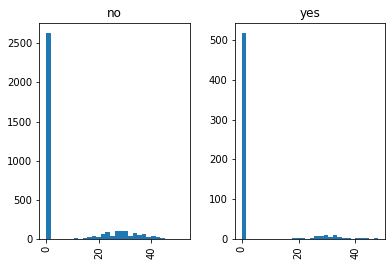

total_day_minutes


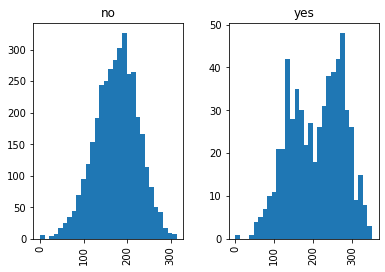

total_day_calls


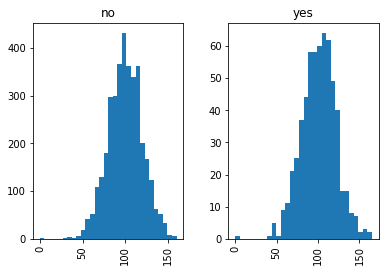

total_day_charge


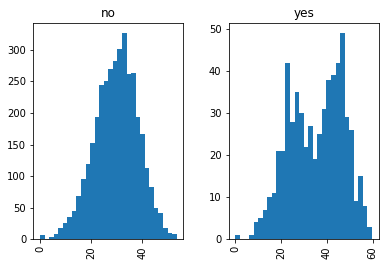

total_eve_minutes


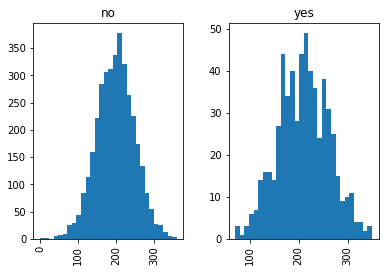

total_eve_calls


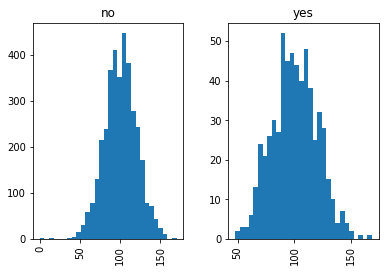

total_eve_charge


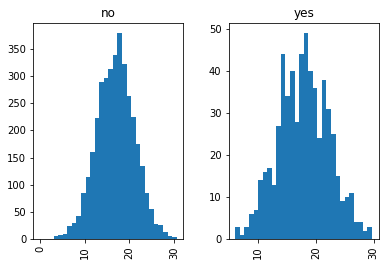

total_night_minutes


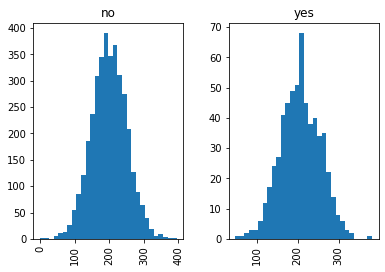

total_night_calls


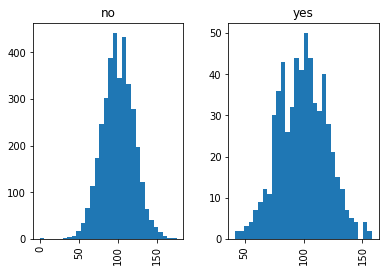

total_night_charge


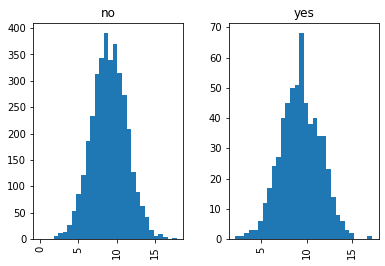

total_intl_minutes


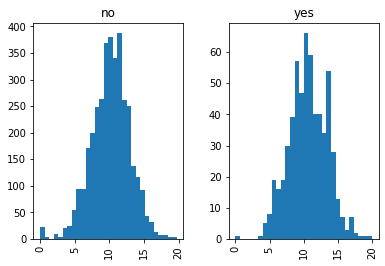

total_intl_calls


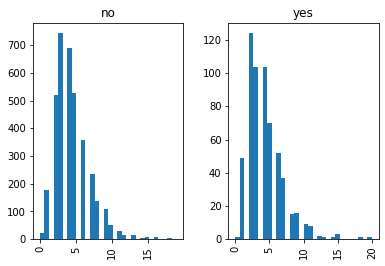

total_intl_charge


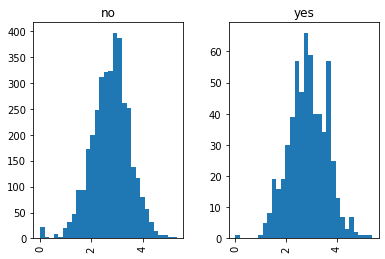

number_customer_service_calls


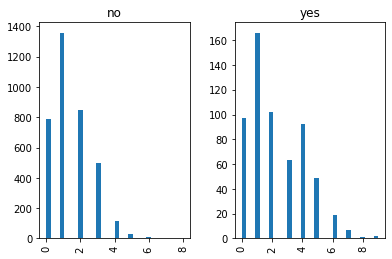

In [110]:
for column in churn_train.select_dtypes(include=['object']).columns:
    if column != 'churn':
        display(pd.crosstab(index=churn_train[column], columns=churn_train['churn'], normalize='columns'))

for column in churn_train.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn_train[[column, 'churn']].hist(by='churn', bins=30)
    plt.show()

- Feature correlation
    - total_day_charge vs total_day_minute : positive
    - total_eve_charge vs total_eve_minute : positive
    - total_night_charge vs total_night_minute : positive
    - total_intl_charge vs total_intl_minute : positive

- Change number_vmail_messages as vmail exist flag : 0 or 1

In [111]:
churn_train['vmail'] = np.where(churn_train['number_vmail_messages'] == 0, 0, 1)

In [112]:
#churn_train = churn_train.drop(['number_vmail_messages','total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes'], axis='columns')
churn_train['total_minutes']=churn_train['total_day_minutes']+churn_train['total_eve_minutes']+churn_train['total_night_minutes']+churn_train['total_intl_minutes']
churn_train['total_calls']=churn_train['total_day_calls']+churn_train['total_eve_calls']+churn_train['total_night_calls']+churn_train['total_intl_calls']
churn_train['total_charge']=churn_train['total_day_charge']+churn_train['total_eve_charge']+churn_train['total_night_charge']+churn_train['total_intl_charge']

In [113]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (2.2.2)


In [114]:
import category_encoders as ce
encoder = ce.target_encoder.TargetEncoder(cols=['state'])
encoder.fit(churn_train['state'], churn_train['total_charge']);
churn_train['trans_State'] = encoder.transform(churn_train['state'])

In [115]:
churn_train = pd.get_dummies(churn_train)

In [116]:
churn_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 4250 non-null   int64  
 1   number_vmail_messages          4250 non-null   int64  
 2   total_day_minutes              4250 non-null   float64
 3   total_day_calls                4250 non-null   int64  
 4   total_day_charge               4250 non-null   float64
 5   total_eve_minutes              4250 non-null   float64
 6   total_eve_calls                4250 non-null   int64  
 7   total_eve_charge               4250 non-null   float64
 8   total_night_minutes            4250 non-null   float64
 9   total_night_calls              4250 non-null   int64  
 10  total_night_charge             4250 non-null   float64
 11  total_intl_minutes             4250 non-null   float64
 12  total_intl_calls               4250 non-null   i

## Split Train Data

- Data Split for training and test
    - Model Training : 70% (X_train, y_train)
    - Model Evaluation : 20% (X_eval, y_eval)
    - Model Testing : 10% (X_test, y_test)

In [117]:
train_data, eval_data, test_data = np.split(churn_train.sample(frac=1, random_state=1729), [int(0.7 * len(churn_train)), int(0.9 * len(churn_train))])

In [118]:
train_data.shape, eval_data.shape, test_data.shape

((2975, 80), (850, 80), (425, 80))

In [119]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2975 entries, 1708 to 1541
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 2975 non-null   int64  
 1   number_vmail_messages          2975 non-null   int64  
 2   total_day_minutes              2975 non-null   float64
 3   total_day_calls                2975 non-null   int64  
 4   total_day_charge               2975 non-null   float64
 5   total_eve_minutes              2975 non-null   float64
 6   total_eve_calls                2975 non-null   int64  
 7   total_eve_charge               2975 non-null   float64
 8   total_night_minutes            2975 non-null   float64
 9   total_night_calls              2975 non-null   int64  
 10  total_night_charge             2975 non-null   float64
 11  total_intl_minutes             2975 non-null   float64
 12  total_intl_calls               2975 non-null 

### Data Format Change

- Amazon SageMaker use libSVM or CSV format
- First column should be target variable
- Remove header

In [120]:
pd.concat([train_data['churn_yes'], train_data.drop(['churn_no', 'churn_yes'], axis=1)], axis=1).to_csv('model_train.csv', index=False, header=False)
pd.concat([eval_data['churn_yes'], eval_data.drop(['churn_no', 'churn_yes'], axis=1)], axis=1).to_csv('model_validation.csv', index=False, header=False)
pd.concat([test_data['churn_yes'], test_data.drop(['churn_no', 'churn_yes'], axis=1)], axis=1).to_csv('model_test.csv', index=False, header=False)
pd.concat([test_data.drop(['churn_no', 'churn_yes'], axis=1)], axis=1).to_csv('model_test_features.csv', index=False, header=False)

- Store to S3 for SageMaker to access

In [121]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/model_train.csv')).upload_file('model_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/model_validation.csv')).upload_file('model_validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/model_test.csv')).upload_file('model_test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/model_test_features.csv')).upload_file('model_test_features.csv')

# Training

- Use ECR container including XGBoost

In [122]:
#from sagemaker.amazon.amazon_estimator import get_image_uri
#container = get_image_uri(boto3.Session().region_name, 'xgboost')

# sagemaker 2.x sdk 에서는 아래를 사용하세요.
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, 'latest')
#container = retrieve('xgboost', boto3.Session().region_name, 'latest')

- Indicate S3 file

In [123]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')
print(train_data)

s3://sagemaker-us-east-1-189427507247/sagemaker/xgboost-churn-prediction/train


In [124]:
validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')
print(validation_data)

s3://sagemaker-us-east-1-189427507247/sagemaker/xgboost-churn-prediction/validation


In [125]:
s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(s3_output_location)

s3://sagemaker-us-east-1-189427507247/sagemaker/xgboost-churn-prediction/xgboost_model_sdk


In [126]:
container = image_uris.retrieve('xgboost', boto3.Session().region_name, 'latest')
train_channel = sagemaker.inputs.TrainingInput(train_data, content_type='text/csv')
valid_channel = sagemaker.inputs.TrainingInput(validation_data, content_type='text/csv')
data_channels = {'train': train_channel, 'validation': valid_channel}

In [127]:
xgb = sagemaker.estimator.Estimator(container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.xlarge',
                                         volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [128]:
xgb.set_hyperparameters(seed=42,
                        objective='binary:logistic',
                        gamma=0.25,
                        learn_rate=1,
                        max_depth=3,
                        reg_lambda=20,
                        scale_pos_weight=1,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        num_round=100)

In [ ]:
xgb.fit(inputs=data_channels, logs=True)

2020-11-05 17:52:07 Starting - Starting the training job...
2020-11-05 17:52:09 Starting - Launching requested ML instances.........
2020-11-05 17:53:41 Starting - Preparing the instances for training...
2020-11-05 17:54:29 Downloading - Downloading input data...
2020-11-05 17:54:59 Training - Downloading the training image..Arguments: train
[2020-11-05:17:55:20:INFO] Running standalone xgboost training.
[2020-11-05:17:55:20:INFO] File size need to be processed in the node: 0.83mb. Available memory size in the node: 8473.1mb
[2020-11-05:17:55:20:INFO] Determined delimiter of CSV input is ','
[17:55:20] S3DistributionType set as FullyReplicated
[17:55:20] 2975x78 matrix with 232050 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-11-05:17:55:20:INFO] Determined delimiter of CSV input is ','
[17:55:20] S3DistributionType set as FullyReplicated
[17:55:20] 850x78 matrix with 66300 entries loaded from /opt/ml/input/data/validation?format=csv&label_col

# Hosting

- Model Monitor

In [103]:
from sagemaker.model_monitor import DataCaptureConfig
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = 'UC-DEMO-xgb-churn-pred-model-monitor-' + timestamp_prefix
print(endpoint_name)

s3_capture_upload_path = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_monitor')
print(s3_capture_upload_path)
data_capture_config = DataCaptureConfig(
                        enable_capture = True,
                        sampling_percentage = 100,
                        destination_s3_uri = s3_capture_upload_path)

UC-DEMO-xgb-churn-pred-model-monitor-2020-11-05-17-30-32
s3://sagemaker-us-east-1-189427507247/sagemaker/xgboost-churn-prediction/xgboost_model_monitor


- Deploy endpoint for real-time prediction

In [105]:
endpoint_name = 'inference-pipeline-ep-' + timestamp_prefix
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge',
                           endpoint_name=endpoint_name)

ClientError: An error occurred (ValidationException) when calling the CreateEndpoint operation: Cannot create already existing endpoint "arn:aws:sagemaker:us-east-1:189427507247:endpoint/inference-pipeline-ep-2020-11-05-17-30-32".

In [86]:
print(endpoint_name)

inference-pipeline-ep-2020-11-05-15-38-03


# Evaluation

In [96]:
test_data.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,churn_no,churn_yes
3521,106,0,196.7,100,33.44,210.2,109,17.87,173.8,83,...,0,0,0,1,0,1,1,0,0,1
2928,110,0,158.6,97,26.96,204.4,123,17.37,182.5,123,...,0,0,0,1,1,0,1,0,1,0
683,83,0,227.9,78,38.74,207.5,115,17.64,211.7,100,...,0,0,0,1,1,0,1,0,1,0
1844,120,0,134.8,94,22.92,204.1,106,17.35,238.4,109,...,0,0,0,1,1,0,1,0,1,0
532,74,0,165.3,120,28.10,198.5,106,16.87,208.5,102,...,0,1,0,0,1,0,1,0,1,0


In [88]:
test_input = test_data.drop(['churn_no', 'churn_yes'], axis=1)

In [89]:
test_input.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
3521,106,0,196.7,100,33.44,210.2,109,17.87,173.8,83,...,0,0,0,0,0,1,0,1,1,0
2928,110,0,158.6,97,26.96,204.4,123,17.37,182.5,123,...,0,0,0,0,0,1,1,0,1,0
683,83,0,227.9,78,38.74,207.5,115,17.64,211.7,100,...,0,0,0,0,0,1,1,0,1,0
1844,120,0,134.8,94,22.92,204.1,106,17.35,238.4,109,...,0,0,0,0,0,1,1,0,1,0
532,74,0,165.3,120,28.10,198.5,106,16.87,208.5,102,...,0,0,0,1,0,0,1,0,1,0


In [94]:
test_input.shape

(425, 78)

- predict function
    - 테스트 데이터셋을 반복(Loop)
    - rows 만큼 미니매치로 나누기
    - 미니배치를 CSV string payloads로 변환 (타겟속성 변수를 제거합니다.)
    - XGBoost 엔드포인트를 호출하고 예측값 수신
    - CSV결과로 리턴된 예측값을 다시 NumPy 배열로 변환

In [92]:
#xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

In [97]:
def predict(data, rows=425):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        print(array)
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
        
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_input.to_numpy())

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


[[106.    0.  196.7 ...   1.    1.    0. ]
 [110.    0.  158.6 ...   0.    1.    0. ]
 [ 83.    0.  227.9 ...   0.    1.    0. ]
 ...
 [102.    0.  157.4 ...   0.    1.    0. ]
 [125.    0.  126.7 ...   0.    1.    0. ]
 [139.    0.  139.  ...   0.    1.    0. ]]
[[ 64.   19.  291.1 ...   0.    0.    1. ]
 [151.    0.  156.4 ...   0.    1.    0. ]
 [ 63.    0.  204.  ...   0.    1.    0. ]
 ...
 [ 72.    0.  272.4 ...   0.    1.    0. ]
 [102.    0.  245.4 ...   0.    1.    0. ]
 [ 60.    0.  221.1 ...   0.    1.    0. ]]


- Compare prediction value with sample data answer

In [100]:
pd.crosstab(index=test_data['churn_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,364,0
1,0,61
